In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_2_torch  ae_res_4_new    ae_res_6_torch
ae_res_1_torch  ae_res_3_new    ae_res_4_torch  data/
ae_res_2_new    ae_res_3_torch  ae_res_5_torch  models/


# Encoder 1

## Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [6]:
autoencoder = AutoEncoder();
learn = Learner(data, autoencoder, loss_func=F.mse_loss);
learn = learn.load('ae_res_1')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


# Encoder 2

## Model

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        first_layer = torch.load('ae_res_1_new')
        decoding = nn.Sequential(*[first_layer.decoder])
        for param in decoding.parameters():
          param.requires_grad = True
        encoding = nn.Sequential(*[first_layer.encoder])
        for param in encoding.parameters():
          param.requires_grad = False
        

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(encoding, resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            decoding
        )
        for param in self.decoder.parameters():
          param.requires_grad = True

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      #decoded = self.full_decode(decoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Training

In [8]:
autoencoder2 = AutoEncoder2();
learn2 = Learner(data, autoencoder2, loss_func=F.mse_loss);

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [9]:
learn2.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [10]:
learn2.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 1.45E-04


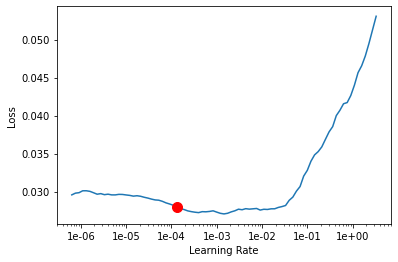

In [11]:
learn2.recorder.plot(suggestion = True)

In [12]:
learn2.fit_one_cycle(100, max_lr = 1e-03)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [13]:
torch.save(autoencoder2, 'ae_res_2_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


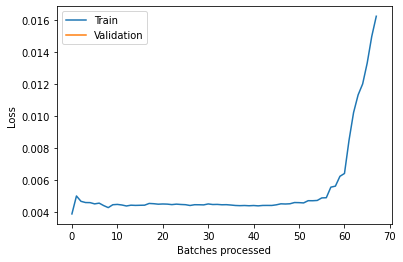

In [20]:
learn2.recorder.plot_losses()

In [0]:
learn2.unfreeze()

In [15]:
learn2.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


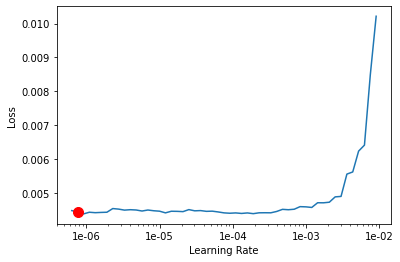

In [16]:
learn2.recorder.plot(suggestion = True)

Once each autoencoder has been saved it does not need to be used again. 

## Look at Results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


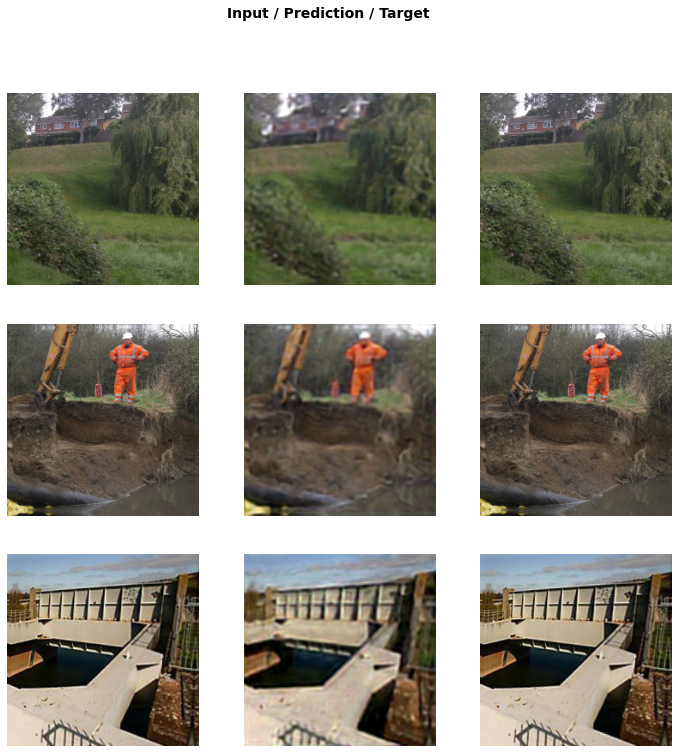

In [18]:
learn2.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


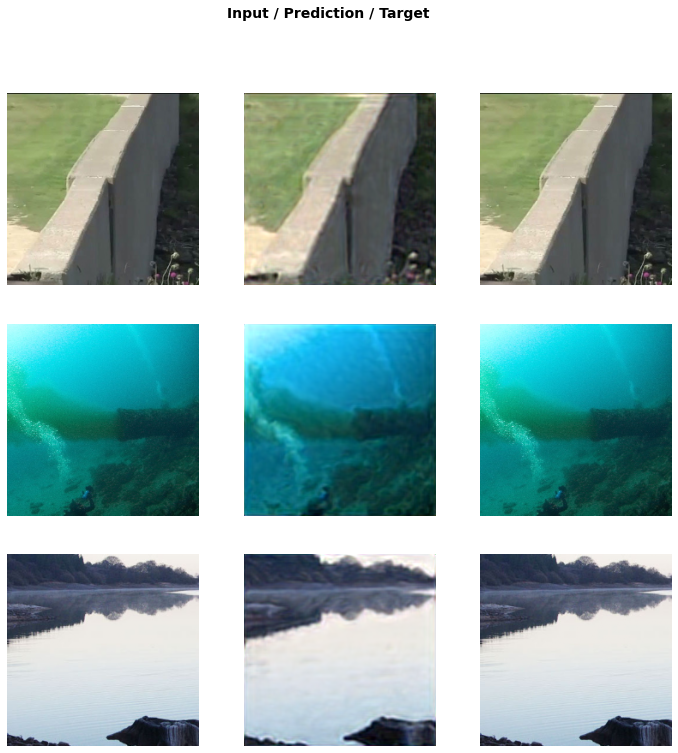

In [19]:
learn2.show_results(ds_type=DatasetType.Valid, rows =3)

# Encoder 3 

## Model

In [0]:
class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()

        first_layer = torch.load('ae_res_2_new')
        decoding = nn.Sequential(*[first_layer.decoder])
        for param in decoding.parameters():
          param.requires_grad = True
        encoding = nn.Sequential(*[first_layer.encoder])
        for param in encoding.parameters():
          param.requires_grad = False
        

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(encoding, resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            decoding
        )
        for param in self.decoder.parameters():
          param.requires_grad = True

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      #decoded = self.full_decode(decoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Training

In [22]:
autoencoder3 = AutoEncoder3();
learn3 = Learner(data, autoencoder3, loss_func=F.mse_loss);

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [23]:
learn3.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [24]:
learn3.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.00E-04


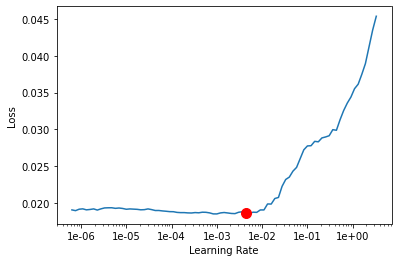

In [25]:
learn3.recorder.plot(suggestion = True)

In [26]:
learn3.fit_one_cycle(100, max_lr = 4.37e-03)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [27]:
torch.save(autoencoder3, 'ae_res_3_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


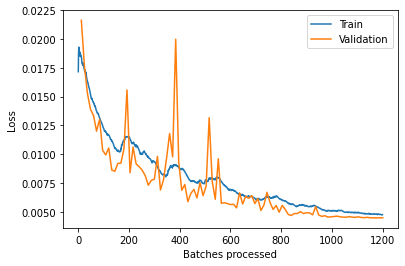

In [29]:
learn3.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


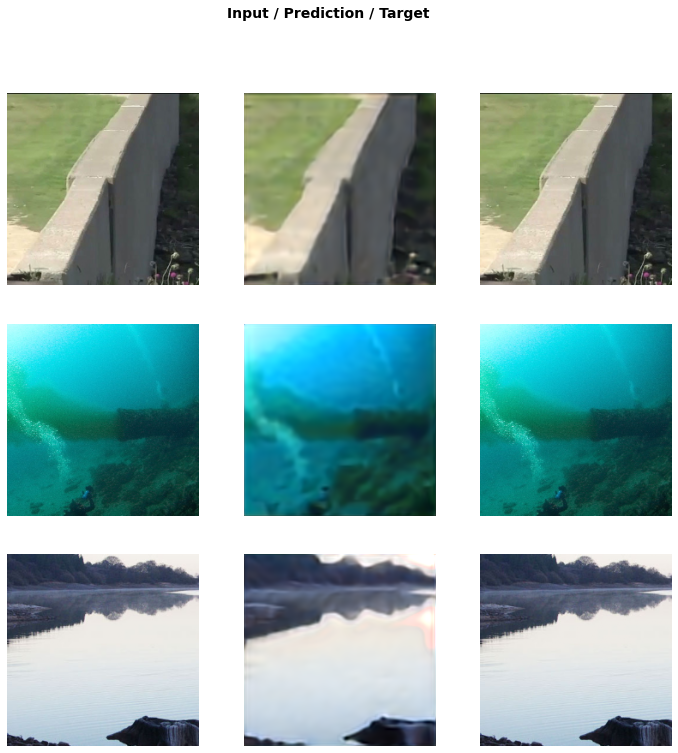

In [30]:
learn3.show_results(ds_type=DatasetType.Valid, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


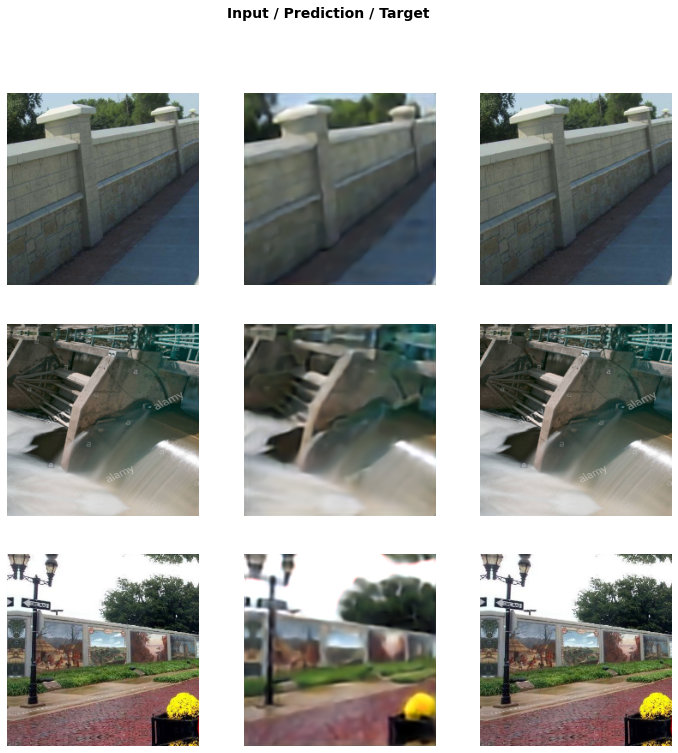

In [31]:
learn3.show_results(ds_type=DatasetType.Train, rows =3)

## Look at Results

# Encoder 4

## Model

In [0]:
class AutoEncoder4(nn.Module):
    def __init__(self):
        super(AutoEncoder4, self).__init__()

        first_layer = torch.load('ae_res_3_new')
        decoding = nn.Sequential(*[first_layer.decoder])
        for param in decoding.parameters():
          param.requires_grad = True
        encoding = nn.Sequential(*[first_layer.encoder])
        for param in encoding.parameters():
          param.requires_grad = False
        

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(encoding, resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            decoding
        )
        for param in self.decoder.parameters():
          param.requires_grad = True

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      #decoded = self.full_decode(decoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Training

In [34]:
autoencoder4 = AutoEncoder4()
learn4 = Learner(data, autoencoder4, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [35]:
learn4.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [36]:
learn4.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-03


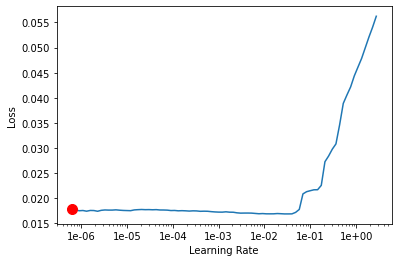

In [37]:
learn4.recorder.plot(suggestion = True)

In [38]:
learn4.fit_one_cycle(100, max_lr = 1e-02)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [46]:
torch.save(autoencoder4, 'ae_res_4_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


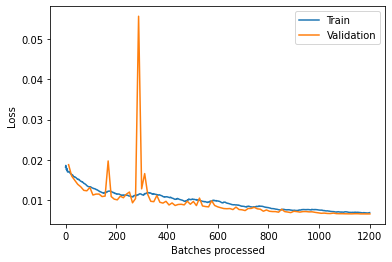

In [40]:
learn4.recorder.plot_losses()

## Look at Results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


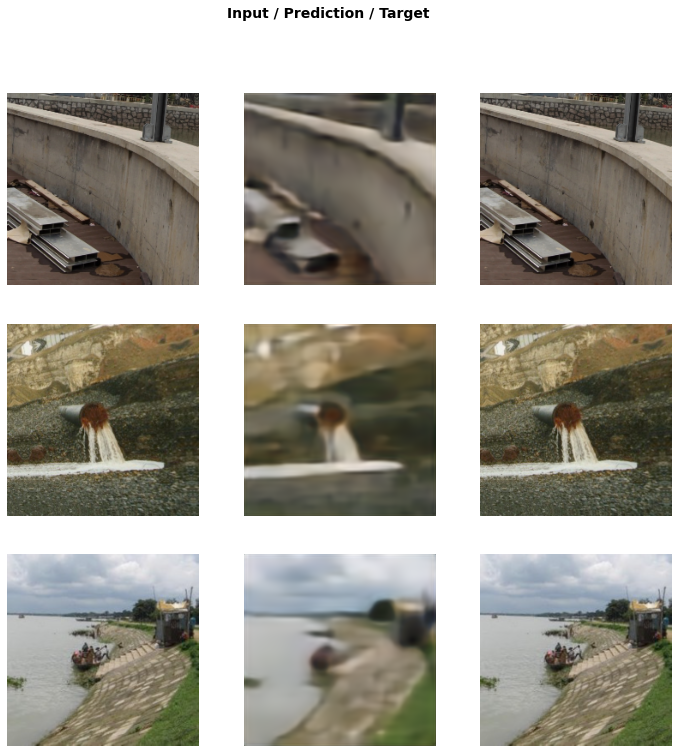

In [41]:
learn4.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


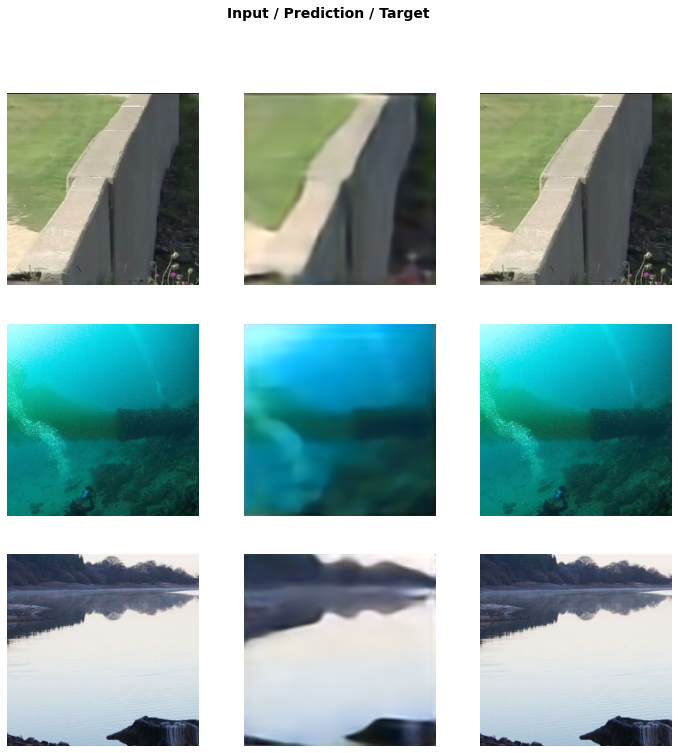

In [42]:
learn4.show_results(ds_type=DatasetType.Valid, rows =3)

# Encoder 5

## Model

In [0]:
class AutoEncoder5(nn.Module):
    def __init__(self):
        super(AutoEncoder5, self).__init__()

        first_layer = torch.load('ae_res_4_new')
        decoding = nn.Sequential(*[first_layer.decoder])
        for param in decoding.parameters():
          param.requires_grad = True
        encoding = nn.Sequential(*[first_layer.encoder])
        for param in encoding.parameters():
          param.requires_grad = False
        

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(encoding, resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            decoding
        )
        for param in self.decoder.parameters():
          param.requires_grad = True

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      #decoded = self.full_decode(decoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [48]:
autoencoder5 = AutoEncoder5()
learn5 = Learner(data, autoencoder5, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [49]:
learn5.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [50]:
learn5.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 8.32E-03


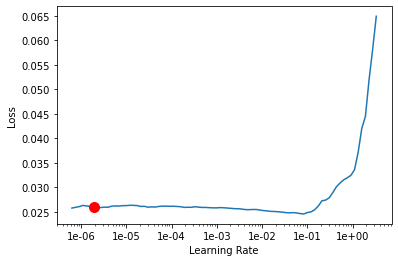

In [51]:
learn5.recorder.plot(suggestion = True)

In [52]:
learn5.fit_one_cycle(100, max_lr = 1.5e-01)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [53]:
torch.save(autoencoder5, 'ae_res_5_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


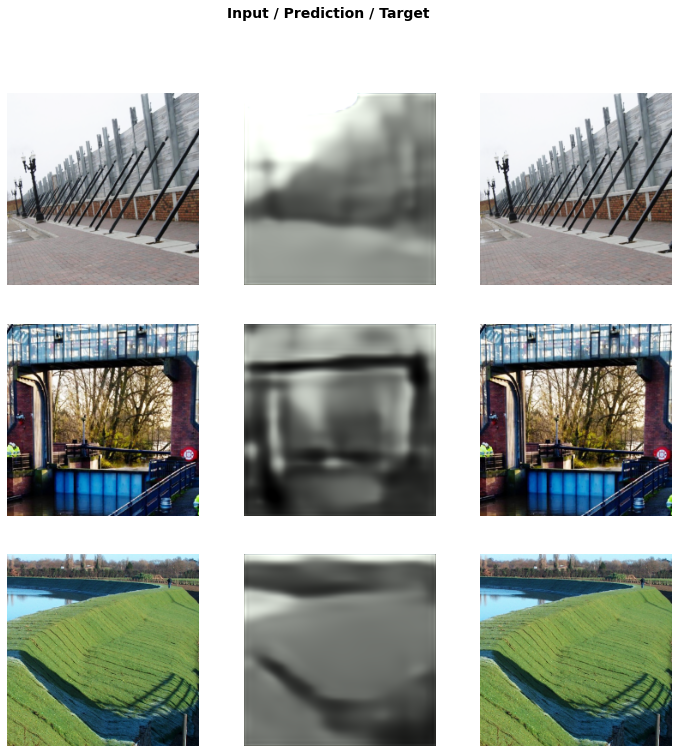

In [54]:
learn5.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


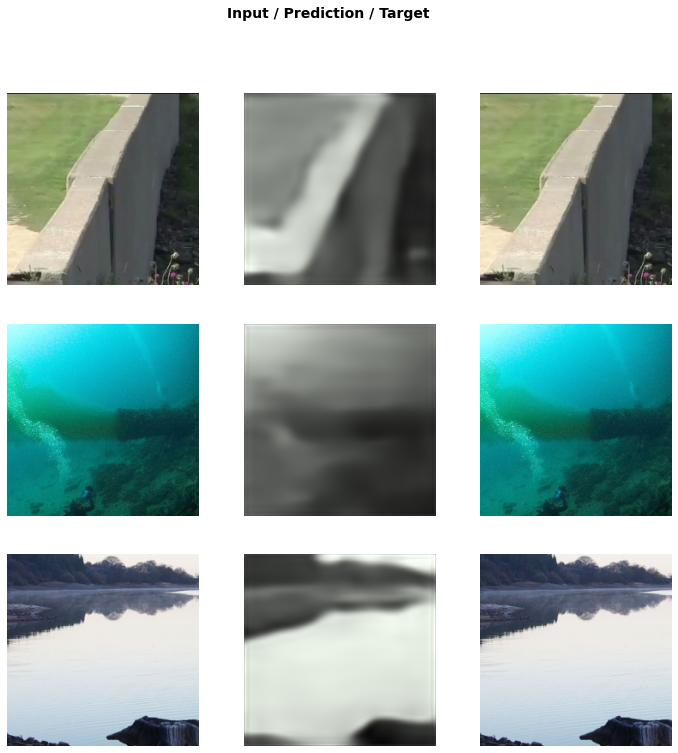

In [55]:
learn5.show_results(ds_type=DatasetType.Valid, rows =3)

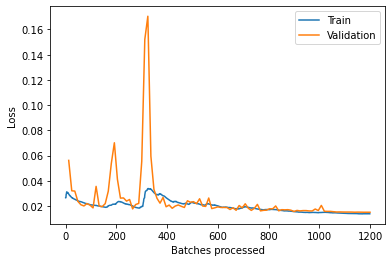

In [56]:
learn5.recorder.plot_losses()

In [57]:
learn5.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


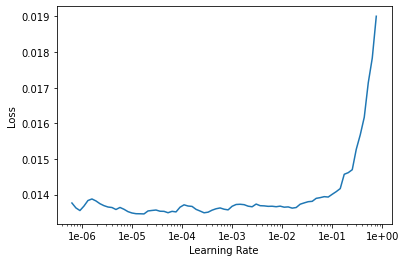

In [58]:
learn5.recorder.plot()

In [0]:
learn5.unfreeze()

In [60]:
learn5.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-07


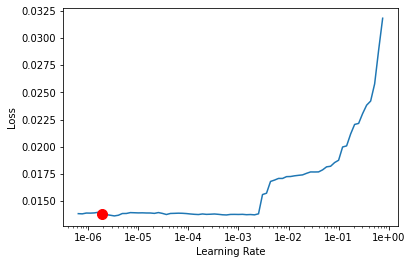

In [61]:
learn5.recorder.plot(suggestion = True)

# Encoder 6

## Model

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
class AutoEncoder6(nn.Module):
    def __init__(self):
        super(AutoEncoder6, self).__init__()

        first_layer = torch.load('ae_res_5_new')
        decoding = nn.Sequential(*[first_layer.decoder])
        for param in decoding.parameters():
          param.requires_grad = True
        encoding = nn.Sequential(*[first_layer.encoder])
        for param in encoding.parameters():
          param.requires_grad = False
        

        self.encoder = nn.Sequential(encoding, AdaptiveConcatPool2d())

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor = 3.5, mode = 'bilinear'),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            decoding
        )
        for param in self.decoder.parameters():
          param.requires_grad = True

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      #decoded = self.full_decode(decoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Training

In [0]:
autoencoder6 = AutoEncoder6()
learn6 = Learner(data, autoencoder6, loss_func = F.mse_loss)

In [69]:
learn6.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [70]:
learn6.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 5.75E-03


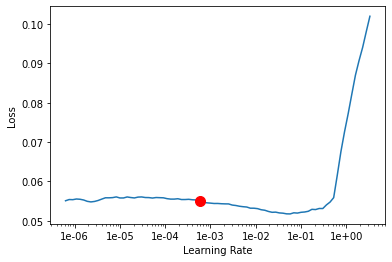

In [71]:
learn6.recorder.plot(suggestion = True)

In [72]:
learn6.fit_one_cycle(100, max_lr = 1e-02)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [74]:
torch.save(autoencoder6, 'ae_res_6_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder6. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdaptiveConcatPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


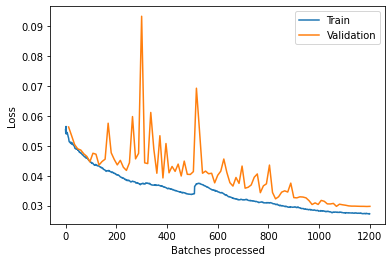

In [75]:
learn6.recorder.plot_losses()

In [76]:
learn6.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.31E-05


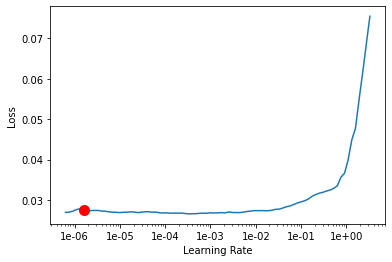

In [77]:
learn6.recorder.plot(suggestion = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


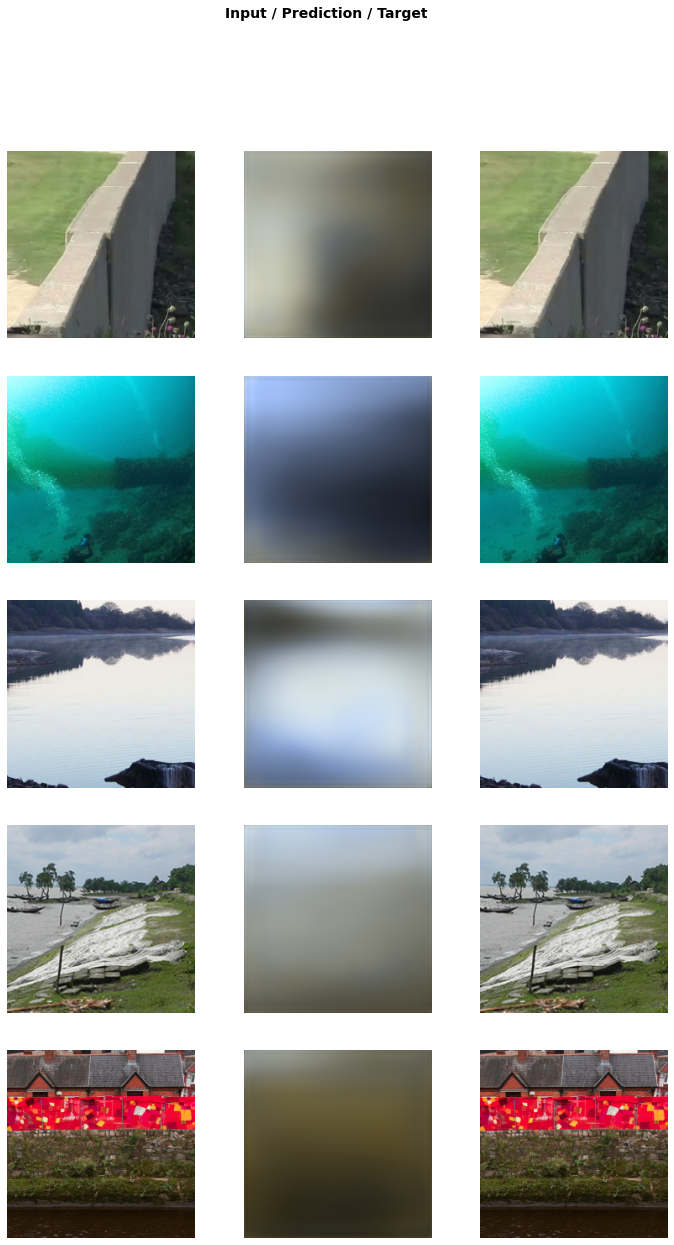

In [78]:
learn6.show_results()

# Full overall model

In [0]:
learn6.unfreeze()

In [0]:
learn6.save('fullModel')

In [82]:
learn6.fit_one_cycle(1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn6 = learn6.load('fullModel')

In [84]:
learn6.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-06


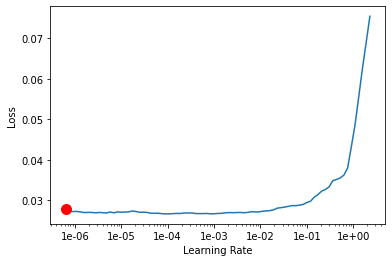

In [85]:
learn6.recorder.plot(suggestion = True)

In [86]:
learn6.fit_one_cycle(10, max_lr = slice(1e-03))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


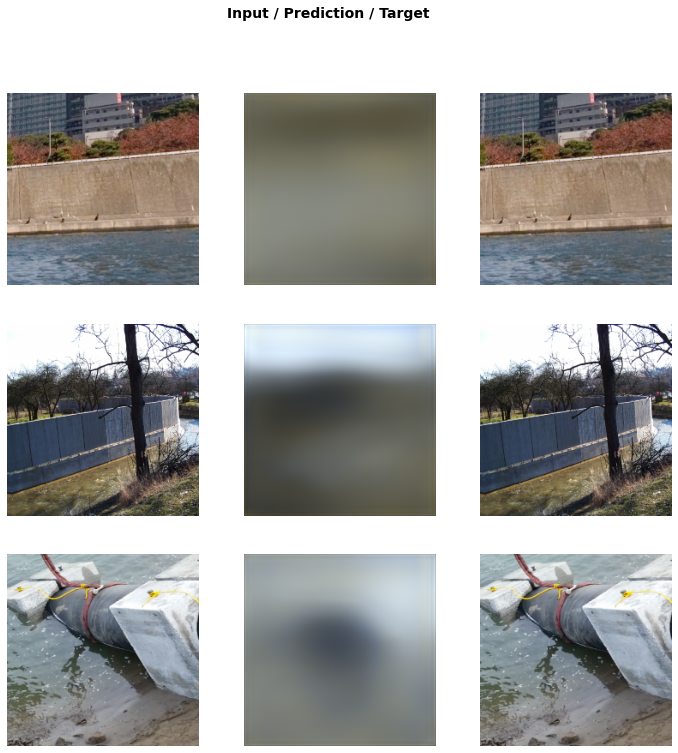

In [90]:
learn6.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


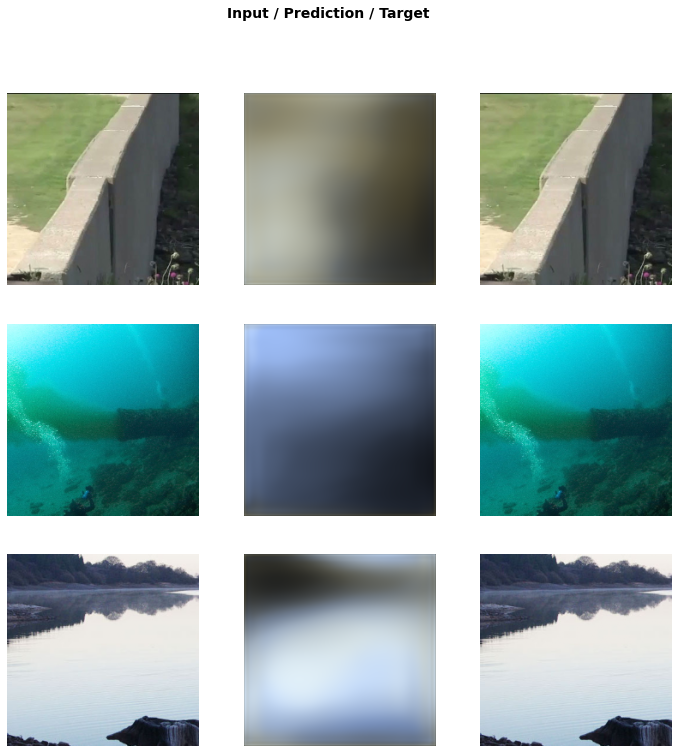

In [91]:
learn6.show_results(ds_type=DatasetType.Valid, rows =3)

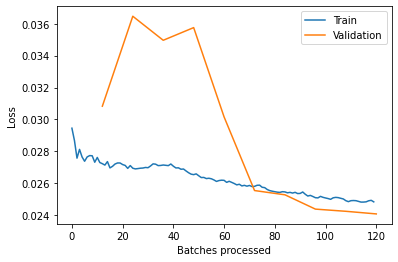

In [89]:
learn6.recorder.plot_losses()

In [92]:
learn6.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-07


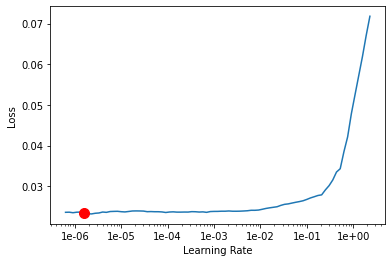

In [93]:
learn6.recorder.plot(suggestion = True)

In [94]:
learn6.fit_one_cycle(50, max_lr = slice(1e-03))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


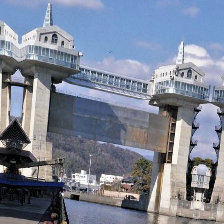

In [95]:
img = data.train_ds[120][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


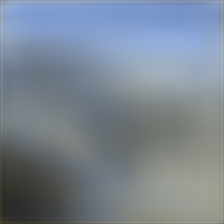

In [103]:
learn6.model.eval()
with torch.no_grad():
  pred = learn6.model(example.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


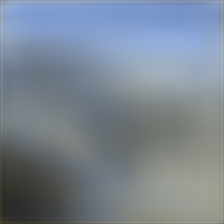

In [99]:
autoencoder6.eval()
with torch.no_grad():
  pred = autoencoder6(example.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

In [100]:
torch.save(autoencoder6, 'final_model')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder6. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdaptiveConcatPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [105]:
learn6.fit_one_cycle(100, max_lr = slice(1e-03))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
